In [1]:
%pylab inline
import pickle
import numpy as np
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
from scipy import ndimage, misc
import jax
import jax_cosmo as jc

In [2]:
field_size=5.
field_npix=1024
pix_scale = 5/1024*60# arcmin
sigma_pix=1/pix_scale

In [3]:
#Loads the jacobians computed from maps without smoothing and noise
ps_jac = []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_ps_pure_maps/jac"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_ps_pure_maps/jac', filename), 'rb'))
        ps_jac.append(res['jac_ps'])

In [4]:
ps_jac= stack(ps_jac, axis=0)

In [5]:
loglog(ps_jac.mean(axis=0))
for i in range(len(ps_jac)):
    loglog(ps_jac[i], alpha=0.2)

In [6]:
mu_jac = ps_jac.mean(axis=0)

In [7]:
# Load maps 
kmaps = []
for filename in os.listdir("/global/cscratch1/sd/dlan/maps/maps"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/maps/maps', filename), 'rb'))
        kmaps.append(res['kmap'])

In [8]:
def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)

In [9]:
# Compute power spectrum
ps_maps=[]
for m in kmaps:
        l, power_spectrum = DHOS.statistics.power_spectrum(m[0], field_size,field_npix)
        # Keep only ell between 300 and 3000
        ell = l[2:46]
        power_spectrum = power_spectrum[2:46]
        # Further reducing the nnumber of points
        ell = rebin(ell, 11)
        power_spectrum = rebin(power_spectrum, 11)
        ps_maps.append(power_spectrum)
        

In [10]:
ps_maps=stack(ps_maps, axis=0)
mu_ps_maps = ps_maps.mean(axis=0)

In [11]:

z_source = np.array([1.])
cosmo=jc.Planck15()
nz =jc.redshift.delta_nz(z_source)
probes = [jc.probes.WeakLensing([nz])] 
cls = jc.angular_cl.angular_cl(cosmo, l.numpy(), probes)


In [12]:
ps_halofit=cls[0]
l = l[2:46]
ps_halofit = ps_halofit[2:46]
# Further reducing the nnumber of points
l= rebin(l, 11)
ps_halofit = rebin(ps_halofit, 11)

In [13]:
style.use('seaborn-whitegrid')
loglog(l, l*(l+1)*mu_ps_maps/(2*np.pi),label='DLL')
loglog(l, l*(l+1)*ps_halofit/(2*np.pi),'--',label='Analytical $halofit$ predictions')
xlim(1e2,1e4)
ylim(4e-9,4e-2)
axvline(300)
axvline(3000)
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
xlabel('$\ell$')
legend()

In [14]:

def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, l.numpy(), probes)
  return m.flatten()
jac_mean = jax.jit(jax.jacfwd(mean_fn))
params = np.array([cosmo.Omega_c, cosmo.sigma8]) 
dmu = jac_mean(params)

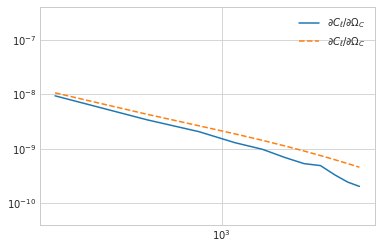

In [26]:
loglog(l,mu_jac[...,0],label='$\partial C_{\ell}/ \partial \Omega_C$')
loglog(l,dmu[...,0],'--',label='$\partial C_{\ell}/ \partial \Omega_C$')
ylim(4e-11,4e-7)
legend()

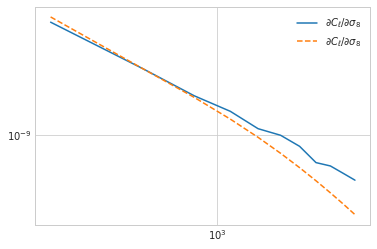

In [27]:
loglog(l,mu_jac[...,1],label='$\partial C_{\ell}/ \partial \sigma_8$')
loglog(l,dmu[...,1],'--',label='$\partial C_{\ell}/ \partial \sigma_8$')
legend()

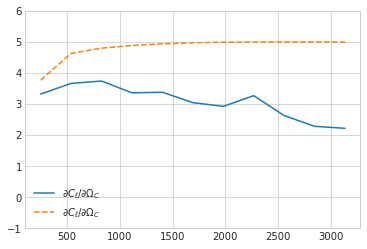

In [30]:
plot(l,mu_jac[...,0]/ps_halofit,label='$\partial C_{\ell}/ \partial \Omega_C$')
plot(l,dmu[...,0]/ps_halofit,'--',label='$\partial C_{\ell}/ \partial \Omega_C$')
ylim(-1,6)
legend()

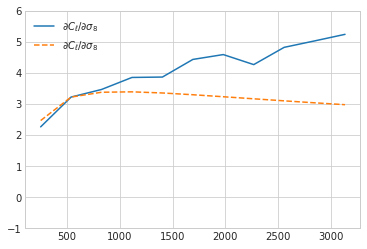

In [31]:
plot(l,mu_jac[...,1]/ps_halofit,label='$\partial C_{\ell}/ \partial \sigma_8$')
plot(l,dmu[...,1]/ps_halofit,'--',label='$\partial C_{\ell}/ \partial \sigma_8$')
ylim(-1,6)
legend()